# Анализ данных и выявление типа поломки промышленной установки.

## Решение задачи мультиклассовой классификации.

Этот набор данных отражает реальное обслуживание промышленных установок, встречающееся в отрасли. Каждая запись в данных представляет собой установку с набором признаков. Наша цель — определить причину сбоя в соответствии со значениями признаков. Для этого мне нужно проанализировать этот набор данных, а затем создать модель, которая может классифицировать тип поломки установки с высоким значением какой-либо метрики (какой именно - определимся в процессе анализа данных). Итак, у меня есть задача машинного обучения, а именно - задача мультиклассовой классификации. Данные имеют следующие признаки:<br>
1) UDI: уникальный идентификатор записи<br>
2) productID: идентификатор установки<br>
3) Type: тип установки<br>
4) Air temperature [K]: температура воздуха в кельвинах<br>
5) Process temperature [K]: температура процесса в кельвинах<br>
6) Rotational speed [rpm]: скорость вращения в об/мин<br>
7) Torque [Nm]: крутящий момент в Нм<br>
8) Tool wear [min]: износ инструмента в минутах<br>
9) Target: есть поломка или нет<br>
10) Failure Type: тип поломки (таргет)

Загрузим в проект необходимые модули, функционал которых мы будем использовать в дальнейшем.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier
import optuna
warnings.filterwarnings('ignore')

Модуль numpy нам предоставляет качественные многомерные массивы, модуль pandas предоставляет серии и датафреймы, в которых удобно хранить данные. Модуль sklearn (scikit-learn) предоставляет нам объёмный функционал для анализа и обработки данных, а также множество моделей для решения задачи мультиклассовой классификации. Модуль imblearn предоставляет нам функционал для работы с несбалансированными классами. Модуль optuna позволяет удобно подбирать оптимальные гиперпараметры в модели. Модули matplotlib и seaborn - популярные фреймворки для визуализации данных. Модуль warnings позволяет отключить всплывающие уведомления.

## Предварительный анализ данных

Выгрузим данные и взглянём на них. Признаки "UDI" и "Product ID" удалим как неинформативные (просто идентификаторы).

In [2]:
data = pd.read_csv("C://machine_maintance/predictive_maintenance.csv")
data = data.drop(['UDI', 'Product ID'], axis=1)
print('First 5 entries')
print(data.head())
print('\nLast 5 entries')
print(data.tail())
print('\nData description')
print(data.describe())
print('\nData technical information')
data.info()

First 5 entries
  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]   
0    M                298.1                    308.6                    1551  \
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure  

Last 5 entries
     Type  Air temperature [K]  Process temperature [K]   
9995    M                298.8                    308.4  \
9996    H                298.9         

Проверим данные на предмет несоответствия:<br>
1) Поломка имеется, но тип поломки - отсутствие поломки<br>
2) Поломка не имеется, но тип поломки указан

In [3]:
print('Data with "Target" = 1 and "Failure Type" = "No Failure"\n')
print((data[data['Target'] == 1])['Failure Type'].value_counts())

incorrect_label_data = data[(data['Target'] == 1) & (data['Failure Type'] == 'No Failure')].index
data.drop(incorrect_label_data, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

print('\nData with "Target" = 0 and "Failure Type" != "No Failure"\n')
print((data[data['Target'] == 0])['Failure Type'].value_counts())

incorrect_label_data = data[(data['Target'] == 0) & (data['Failure Type'] != 'No Failure')].index
data.drop(incorrect_label_data, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

Data with "Target" = 1 and "Failure Type" = "No Failure"

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

Data with "Target" = 0 and "Failure Type" != "No Failure"

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64


Такие данные имеются для обоих случаев: удалим их.

In [4]:
incorrect_label_data = data[(data['Target'] == 1) & (data['Failure Type'] == 'No Failure')].index
data.drop(incorrect_label_data, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
incorrect_label_data = data[(data['Target'] == 0) & (data['Failure Type'] != 'No Failure')].index
data.drop(incorrect_label_data, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
print("Data with 'Target' = 1\n")
print((data[data['Target'] == 1])['Failure Type'].value_counts())
print("\nData with 'Target' = 0\n")
print((data[data['Target'] == 0])['Failure Type'].value_counts())

Data with 'Target' = 1

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Name: count, dtype: int64

Data with 'Target' = 0

Failure Type
No Failure    9643
Name: count, dtype: int64


Удалим признак "наличие поломки", сведя таким образом задачу к мультиклассовой классификации.

In [5]:
data.drop('Target', axis=1, inplace=True)

Проверим данные на наличие пропущенных значений

In [6]:
missing_values = data.isna().sum().sum()
print('missing values: ', missing_values)

missing values:  0


Пропущенных значений не имеется. Проверим данные на предмет дубликатов.

In [7]:
duplicated_values = data.duplicated().sum()
print('Duplicated values: ', duplicated_values)

Duplicated values:  0


Дубликатов не имеется. Посмотрим на кардинальность каждого признака.

In [8]:
unique_values = data.nunique()
print('Unique values:\n\n', unique_values)

Unique values:

 Type                         3
Air temperature [K]         93
Process temperature [K]     82
Rotational speed [rpm]     941
Torque [Nm]                577
Tool wear [min]            246
Failure Type                 5
dtype: int64


Посмотрим на распределение причин поломок.

In [9]:
target_values = data['Failure Type'].value_counts()
print('Types of target:\n\n', target_values)

Types of target:

 Failure Type
No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: count, dtype: int64


Видим, что классы сильно несбалансированные.

Проанализируем данные на предмет выбросов.

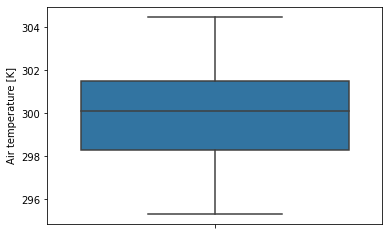

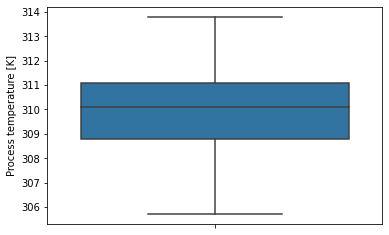

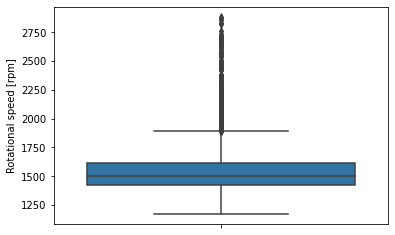

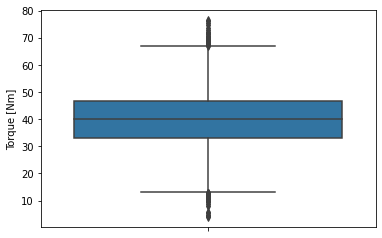

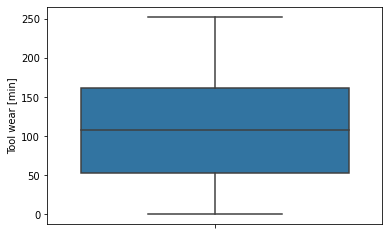

In [10]:
fig = plt.figure()
sns.boxplot(data=data, y='Air temperature [K]')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Process temperature [K]')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Rotational speed [rpm]')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Torque [Nm]')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Tool wear [min]')
plt.xticks(fontsize=5)
plt.show()

Есть подозрения, что признаки "Скорость вращения" и "Крутящий момент" содержат выбросы. Разберёмся с ними более детально: рассмотрим данные, которые идентифицируются как выбросы.

In [11]:
def get_max_min(feature):
    Q1 = feature.quantile(0.25)
    Q3 = feature.quantile(0.75)
    IQR = Q3 - Q1
    max = Q3 + 1.5*IQR
    min = Q1 - 1.5*IQR
    print(f'Max of {feature.name} is {max}, min of {feature.name} is {min}')
    return max, min

max_min_rs = get_max_min(data['Rotational speed [rpm]'])
max_min_torque = get_max_min(data['Torque [Nm]'])
data_rs_above_max = data[data['Rotational speed [rpm]'] > max_min_rs[0]]
data_rs_below_min = data[data['Rotational speed [rpm]'] < max_min_rs[1]]
data_torque_above_max = data[data['Torque [Nm]'] > max_min_torque[0]]
data_torque_below_min = data[data['Torque [Nm]'] < max_min_torque[1]]
print(str((len(data_rs_below_min) + len(data_rs_above_max) + len(data_torque_above_max) + len(data_torque_below_min)) / len(data) * 100)+'%', 'of data are extremal values')

Max of Rotational speed [rpm] is 1895.5, min of Rotational speed [rpm] is 1139.5
Max of Torque [Nm] is 66.95, min of Torque [Nm] is 12.950000000000003
4.893211671513085% of data are extremal values


При более подробном рассмотрении "выбросов" (4,89% данных) можно заметить, что они существенно не отличаются от иных объектов и вполне могут рассматриваться как экстремальные значения. Тем не менее, в дальнейшем будем относиться к ним с осторожностью.

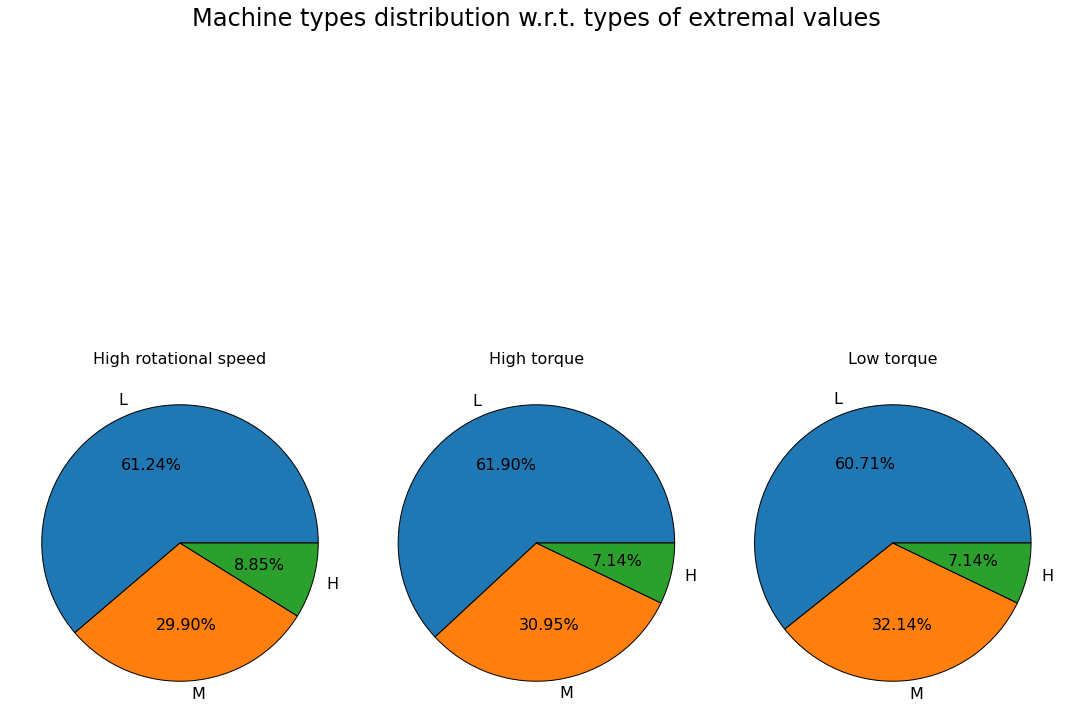

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15,15))
fig.suptitle('Machine types distribution w.r.t. types of extremal values', fontsize=24)
ax[0].pie(data_rs_above_max['Type'].value_counts(normalize=True), labels=['L', 'M', 'H'], autopct='%1.2f%%', wedgeprops={'edgecolor':'black'}, textprops={'fontsize': 16})
ax[1].pie(data_torque_above_max['Type'].value_counts(normalize=True), labels=['L', 'M', 'H'], autopct='%1.2f%%', wedgeprops={'edgecolor':'black'}, textprops={'fontsize': 16})
ax[2].pie(data_torque_below_min['Type'].value_counts(normalize=True), labels=['L', 'M', 'H'], autopct='%1.2f%%', wedgeprops={'edgecolor':'black'}, textprops={'fontsize': 16})
ax[0].set_title('High rotational speed', fontsize=16)
ax[1].set_title('High torque', fontsize=16)
ax[2].set_title('Low torque', fontsize=16)
plt.tight_layout()
plt.show()

Заметим, что распределение типов установок примерно одинаковое при различных типах экстремальных значений.

## Исследовательский анализ данных (EDA)

Закодируем категориальный признак "Тип установки" через one-hot encoder.

In [13]:
onehot = OneHotEncoder(sparse_output=False).fit_transform(data['Type'].to_numpy()[:, None])
onehot = pd.DataFrame(onehot, columns=['H', 'L', 'M'])
data_onehotted = pd.concat([onehot, data.drop('Type', axis=1)], axis=1)

Построим корреляционную матрицу и взглянём на зависимость одних признаков от других.

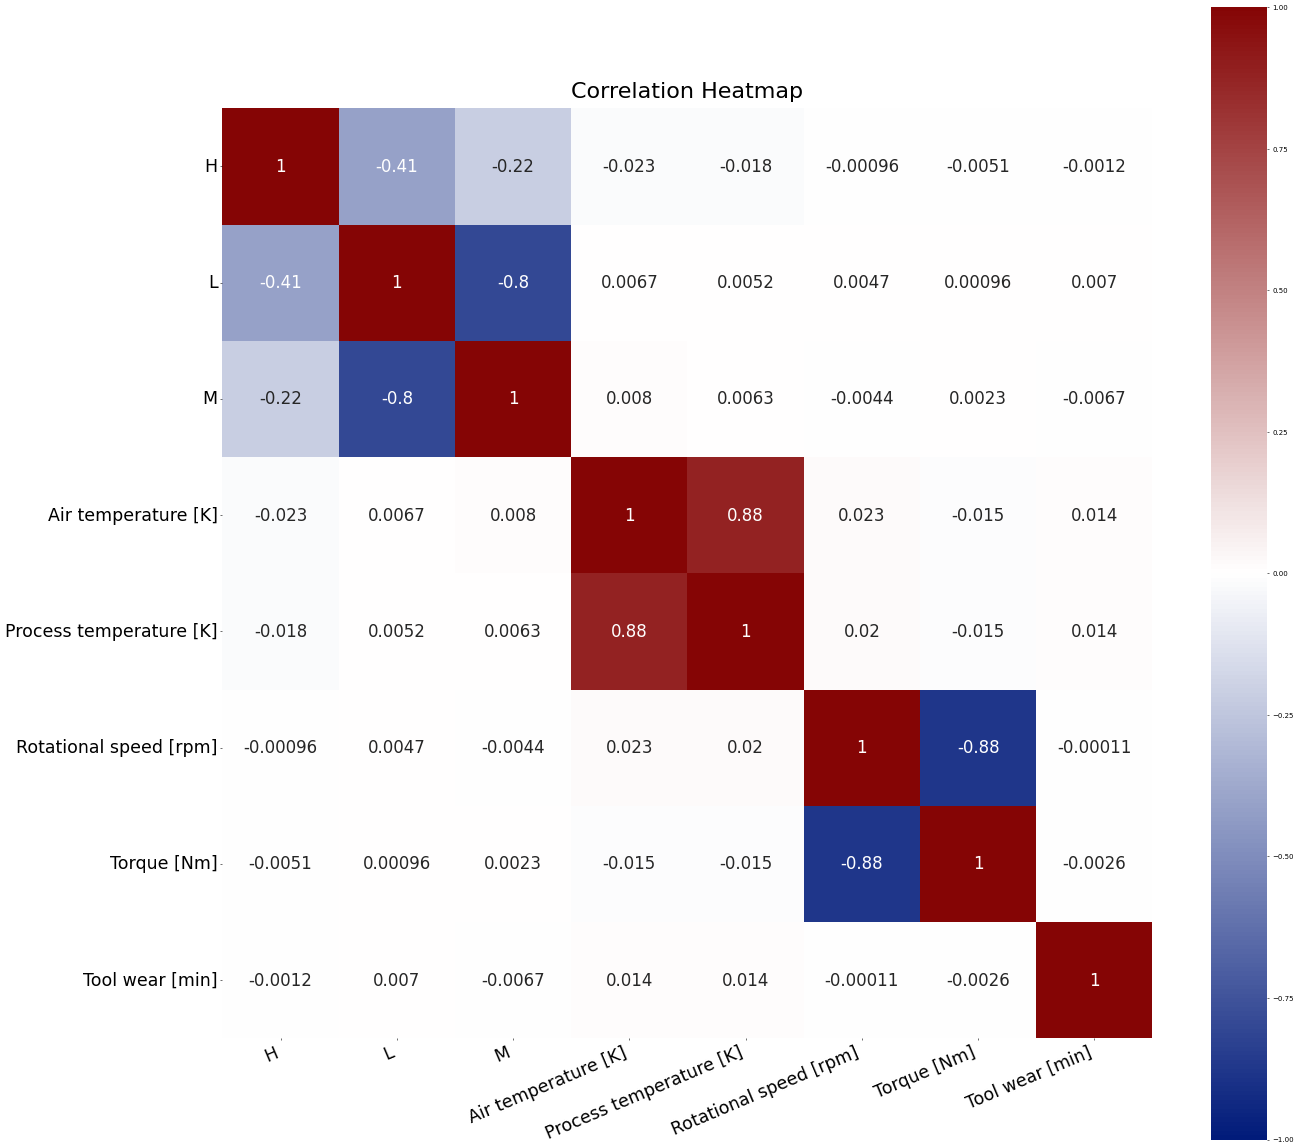

In [14]:
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#011b7a', 'white', '#850505'])
fig, ax = plt.subplots(figsize=(30, 30), dpi=50)
heatmap = sns.heatmap(data_onehotted.drop('Failure Type', axis=1).corr(), cmap=custom_cmap, annot=True, annot_kws={'size':24}, vmin=-1, center=0, vmax=1, square=True)
heatmap.set_title('Correlation Heatmap', fontsize=32, pad=16)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=23, ha='right')
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
plt.show()

Имеется корреляция между типами установок - последствия ван-хот энкодинга. Также имеется прямая корреляция между температурой процесса и температурой воздуха и обратная корреляция между крутящим моментом и скоростью вращения.

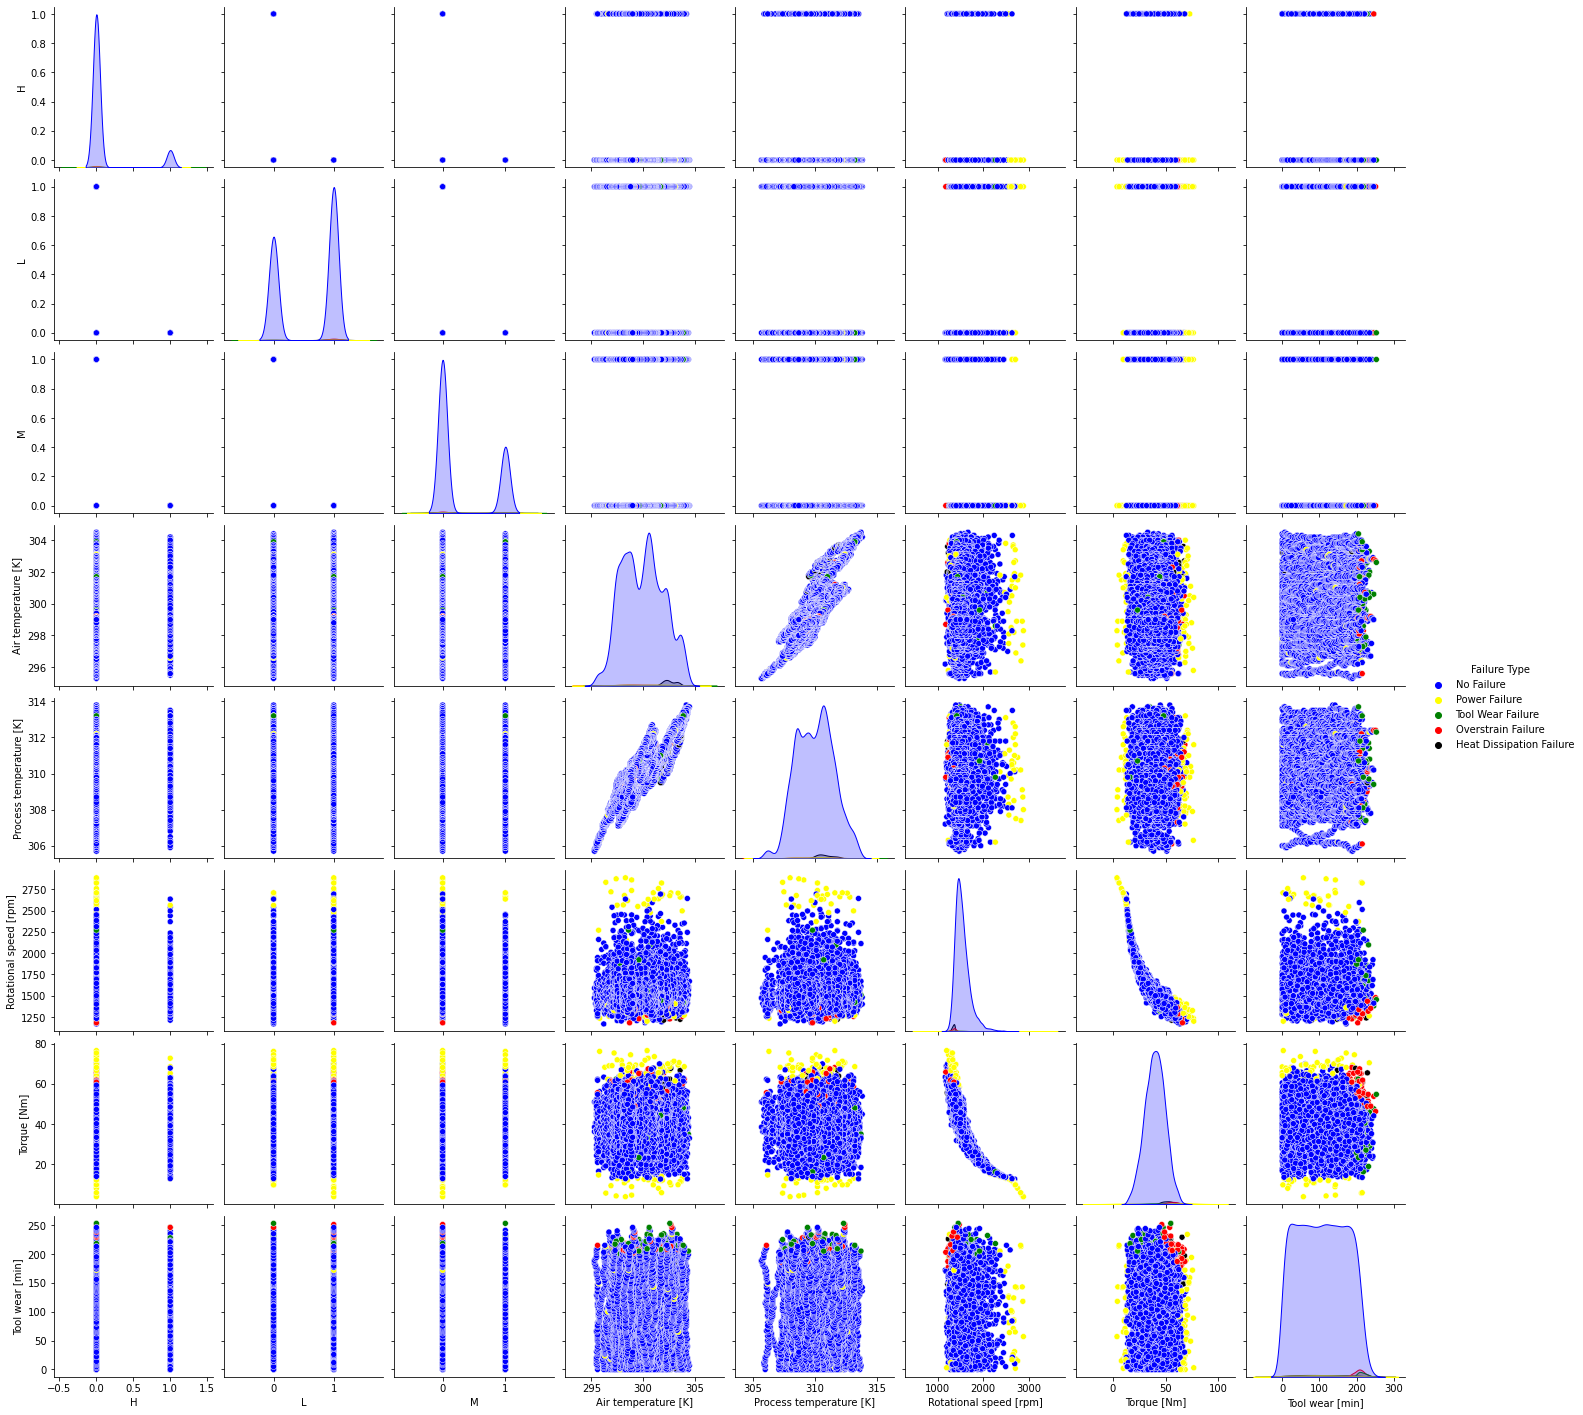

In [15]:
pairplot = sns.pairplot(data_onehotted, hue='Failure Type', palette=['blue', 'yellow', 'green', 'red', 'black'])
plt.show()

По представленной выше сетке из графиков попарных сравнений видно, что те или иные поломки происходят ввиду достижения некоторыми параметрами экстремальных значений. Сбой питания (power failure) происходит в основном из-за достижения слишком большой (малой) вращательной скорости или крутящего момента (как видно - данные признаки имеют обратную корреляцию). Износ машины (tool wear failure) происходит в основном из-за превышения времени износа. Отказ из-за перенапряжения (overstrain failure) происходит при превышения времени износа, либо при превышении крутящего момента (занижении вращательной скорости). Сбой отвода тепла (heat dissipation failure) происходит в основном из-за превышения крутящего момента (занижения скорости вращения), либо превышения температуры воздуха и процесса.

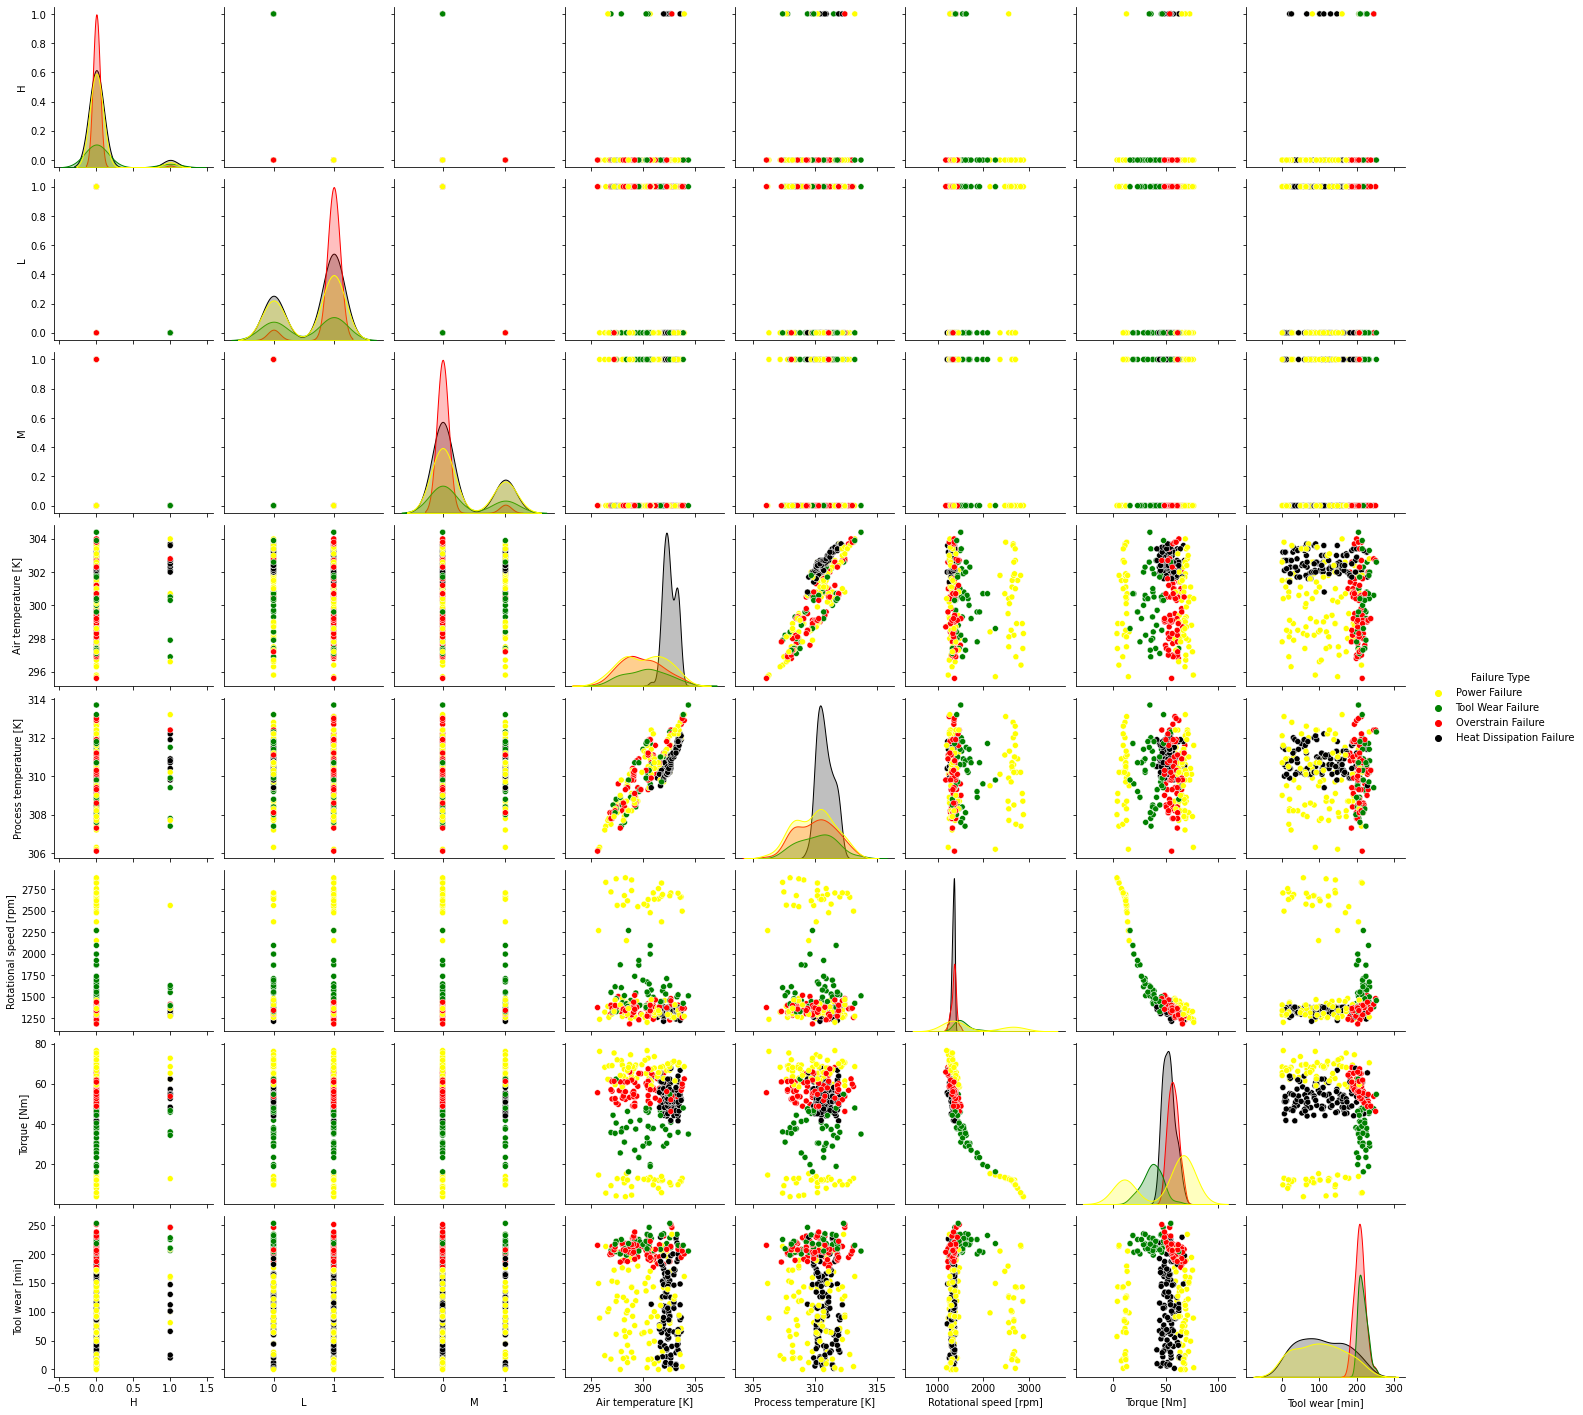

In [16]:
pairplot = sns.pairplot(data_onehotted[data_onehotted['Failure Type'] != 'No Failure'], hue='Failure Type', palette=['yellow', 'green', 'red', 'black'])
plt.show()

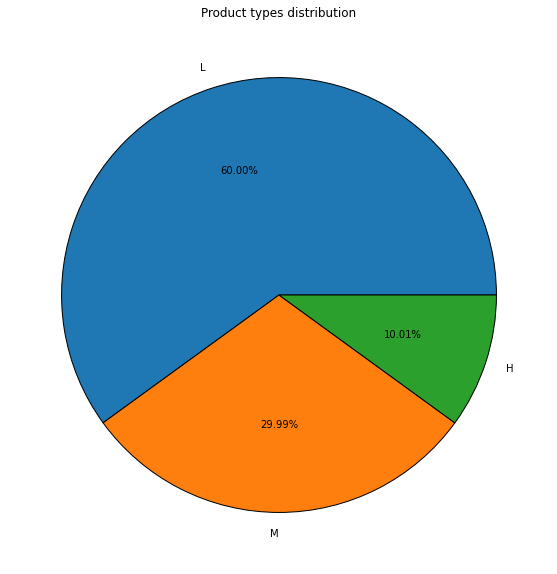

In [17]:
fig = plt.figure(figsize=(10,10))
plt.pie(data['Type'].value_counts(normalize=True), labels=['L', 'M', 'H'], autopct='%1.2f%%', wedgeprops={'edgecolor':'black'})
plt.title('Product types distribution')
plt.show()

Из диаграммы видно, что большая часть установок имеет тип L, меньшая - имеет тип H.

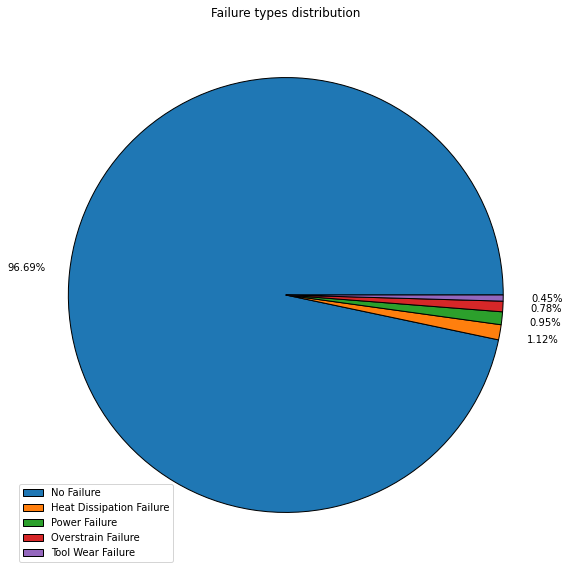

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.pie(data['Failure Type'].value_counts(normalize=True), autopct='%1.2f%%', wedgeprops={'edgecolor':'black'}, pctdistance=1.2)
plt.legend(labels=['No Failure', 'Heat Dissipation Failure', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure'], loc='lower left')
plt.title('Failure types distribution')
plt.show()

Из диаграммы видно, что большая часть поломок (более 1%) происходит по причине сбоя отвода тепла.

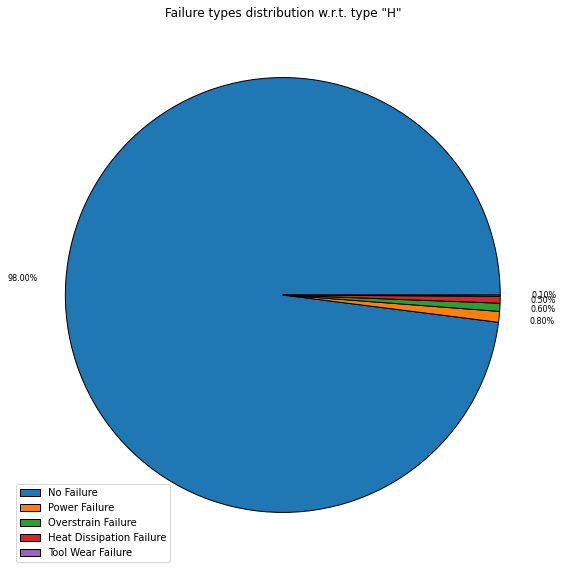

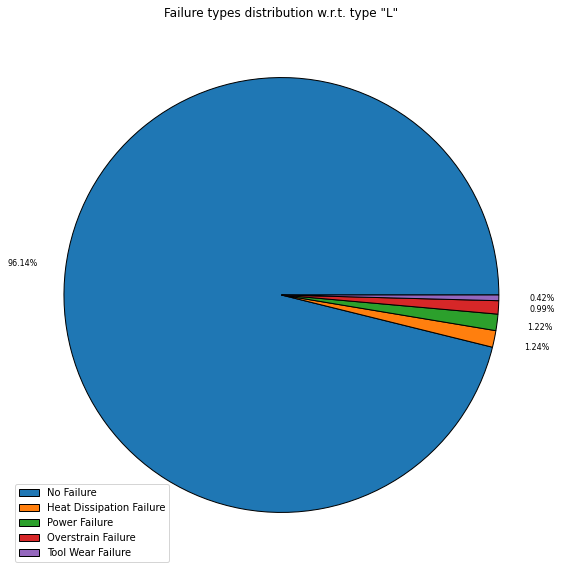

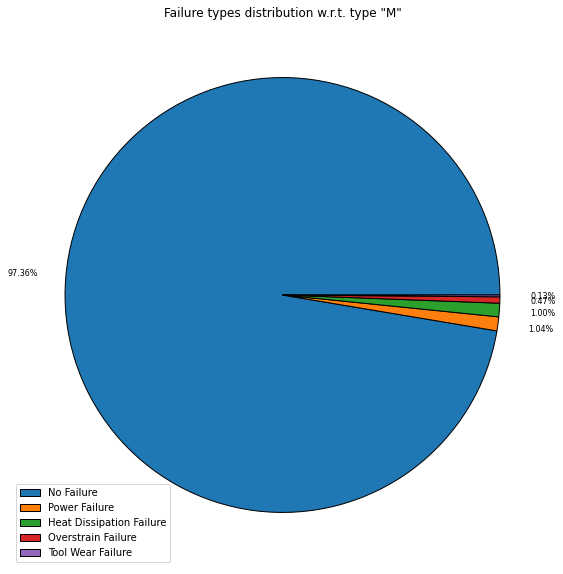

In [19]:
fig = plt.figure(figsize=(10,10))
plt.pie(data_onehotted[data_onehotted['H'] == 1]['Failure Type'].value_counts(normalize=True), autopct='%1.2f%%', wedgeprops={'edgecolor':'black'}, pctdistance=1.2, textprops={'fontsize':8})
plt.legend(labels=['No Failure', 'Power Failure', 'Overstrain Failure', 'Heat Dissipation Failure', 'Tool Wear Failure'], loc='lower left')
plt.title('Failure types distribution w.r.t. type "H"')
plt.show()
fig = plt.figure(figsize=(10,10))
plt.pie(data_onehotted[data_onehotted['L'] == 1]['Failure Type'].value_counts(normalize=True), autopct='%1.2f%%', wedgeprops={'edgecolor':'black'}, pctdistance=1.2, textprops={'fontsize':8})
plt.legend(labels=['No Failure', 'Heat Dissipation Failure', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure'], loc='lower left')
plt.title('Failure types distribution w.r.t. type "L"')
plt.show()
fig = plt.figure(figsize=(10,10))
plt.pie(data_onehotted[data_onehotted['M'] == 1]['Failure Type'].value_counts(normalize=True), autopct='%1.2f%%', wedgeprops={'edgecolor':'black'}, pctdistance=1.2,textprops={'fontsize':8})
plt.legend(labels=['No Failure', 'Power Failure', 'Heat Dissipation Failure', 'Overstrain Failure', 'Tool Wear Failure'], loc='lower left')
plt.title('Failure types distribution w.r.t. type "M"')
plt.show()

Распределение типов поломок для установок различных типов примерно одинаково.

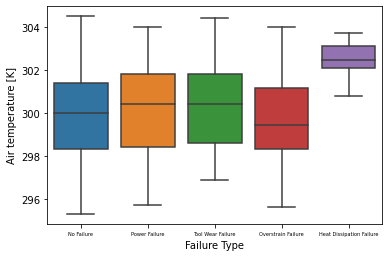

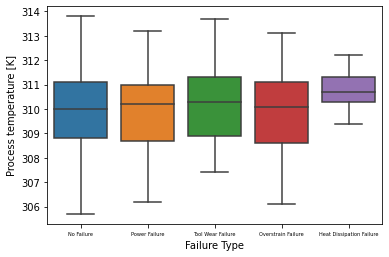

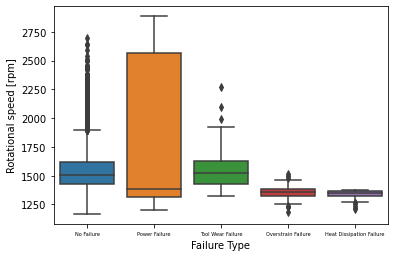

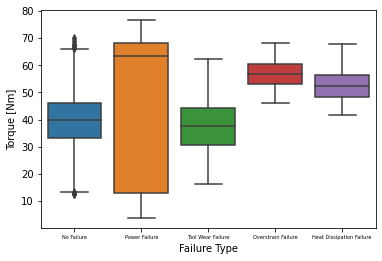

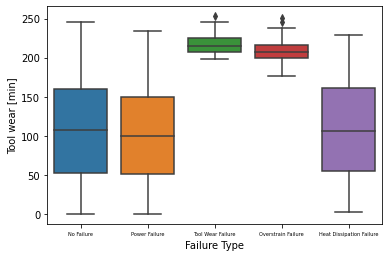

In [20]:
fig = plt.figure()
sns.boxplot(data=data, y='Air temperature [K]', x='Failure Type')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Process temperature [K]', x='Failure Type')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Rotational speed [rpm]', x='Failure Type')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Torque [Nm]', x='Failure Type')
plt.xticks(fontsize=5)
plt.show()

fig = plt.figure()
sns.boxplot(data=data, y='Tool wear [min]', x='Failure Type')
plt.xticks(fontsize=5)
plt.show()

Из представленных графиков видно, что для сбоя отвода тепла температура процесса и температура воздуха в среднем выше, чем температуры при иных типах поломок, либо при безаварийной работе. Для сбоя питания межквартильный размах значений крутящего момента и вращательной скорости в разы больше, чем для остальных типов поломок и для безаварийной работы. Для сбоев из-за перенапряжения и отвода тепла крутящий момент в среднем сильно выше, чем для безаварийной работы (вращательная скорость слишком низка ввиду обратной корреляции признаков). Для сбоев из-за износа и перенапряжения время износа в среднем сильно больше, чем для остальных типов поломок и для безаварийной работы.

Взглянём на распределение признаков.

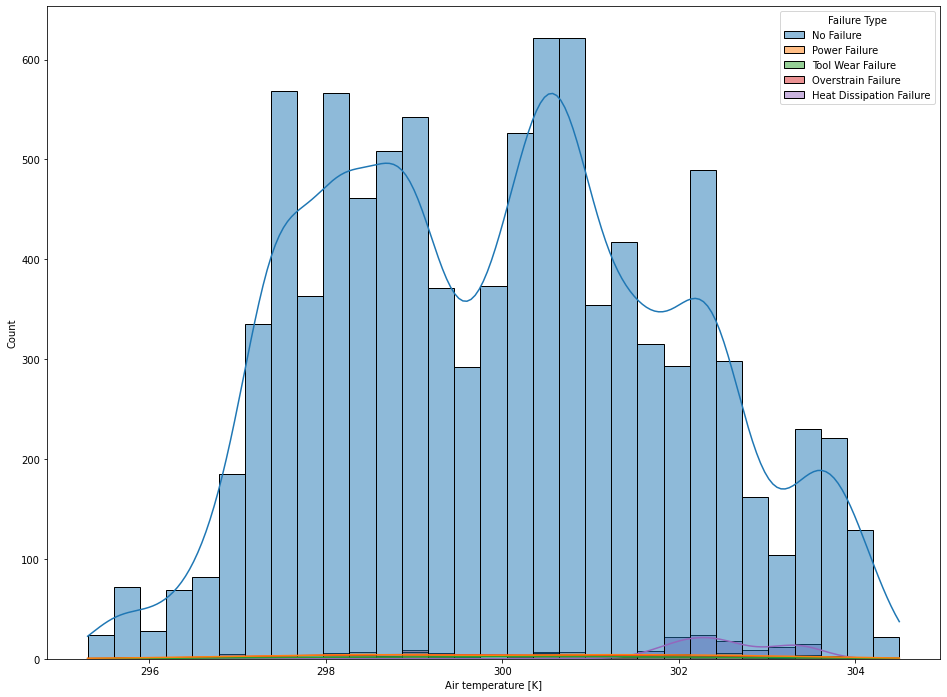

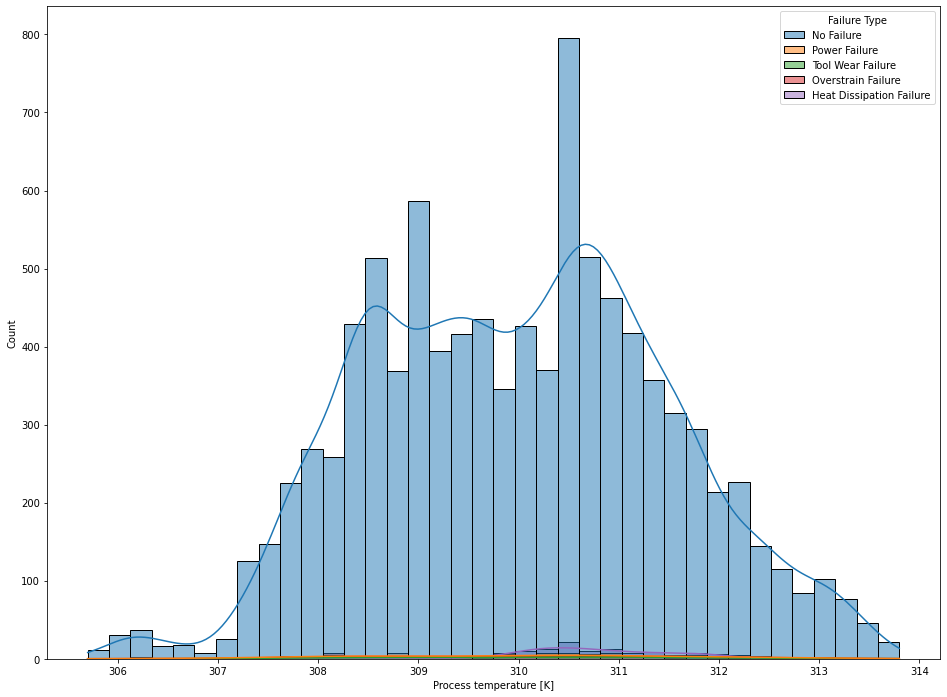

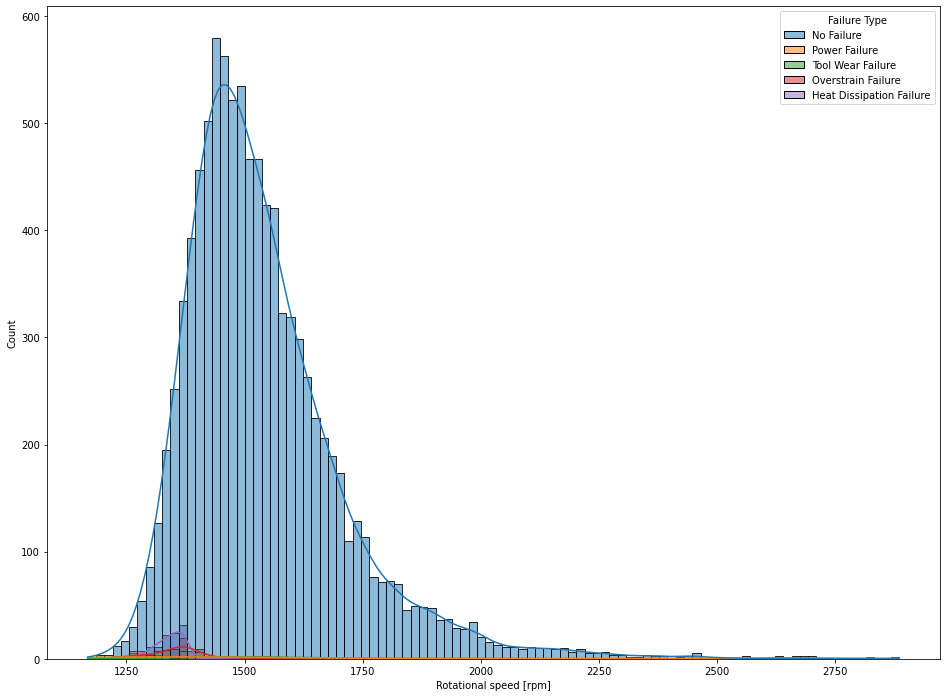

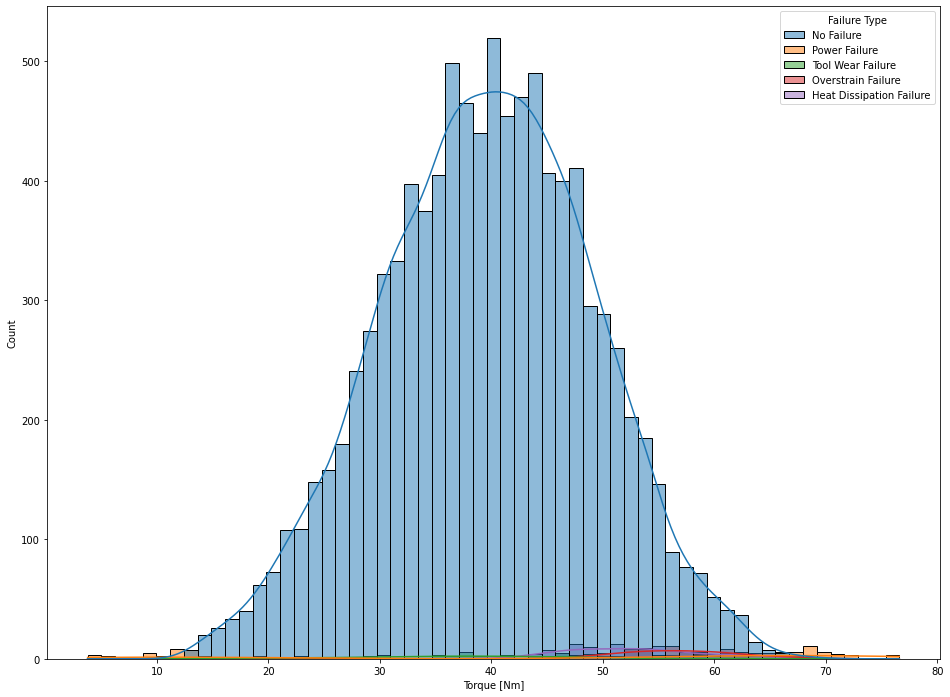

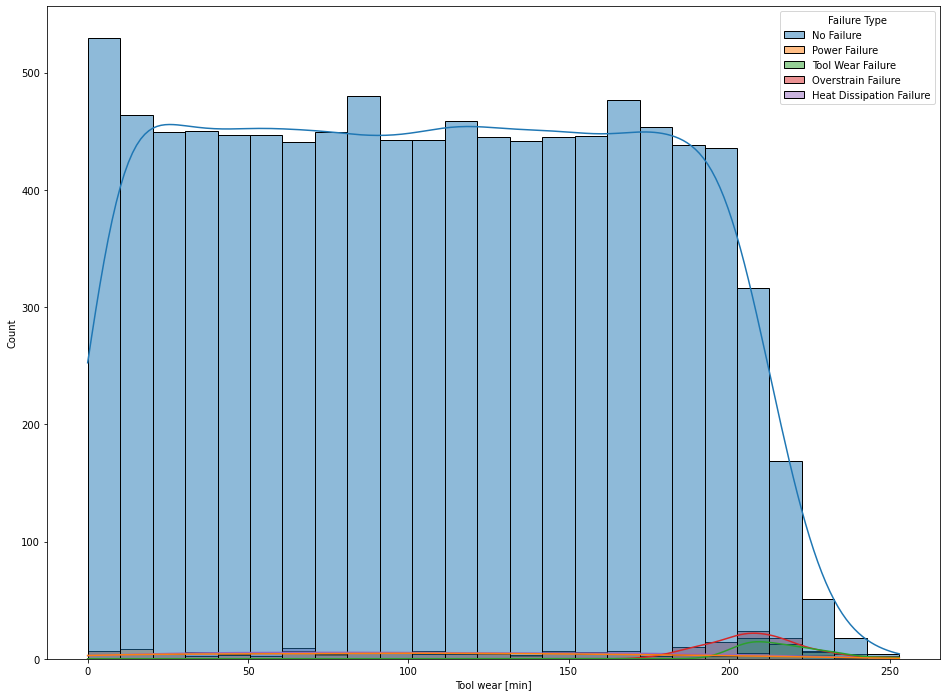

Air temperature [K] skewness is 0.11547298513079587
Process temperature [K] skewness is 0.01618578951511603
Rotational speed [rpm] skewness is 1.9928590857868387
Torque [Nm] skewness is -0.009719368019357482
Tool wear [min] skewness is 0.0284943512122851


In [21]:
fig = plt.figure(figsize=(16, 12))
sns.histplot(data=data, x='Air temperature [K]', kde=True, hue='Failure Type')
plt.show()

fig = plt.figure(figsize=(16, 12))
sns.histplot(data=data, x='Process temperature [K]', kde=True, hue='Failure Type')
plt.show()

fig = plt.figure(figsize=(16, 12))
sns.histplot(data=data, x='Rotational speed [rpm]', kde=True, hue='Failure Type')
plt.show()

fig = plt.figure(figsize=(16, 12))
sns.histplot(data=data, x='Torque [Nm]', kde=True, hue='Failure Type')
plt.show()

fig = plt.figure(figsize=(16, 12))
sns.histplot(data=data, x='Tool wear [min]', kde=True, hue='Failure Type')
plt.show()

for i in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    print(f'{i} skewness is {data[i].skew()}')

Видим, что коэффициент асимметрии положителен для вращательной скорости: распределение сдвинуто влево.

## Анализ и отбор признаков

In [22]:
labels = data_onehotted['Failure Type'].unique()
label2int = LabelEncoder().fit(labels)
print(label2int.classes_)
int_labels = label2int.transform(labels)
int_target = pd.DataFrame(label2int.transform(data_onehotted['Failure Type']), columns=['Failure Type'])
preprocessed_data = pd.concat([data_onehotted.drop('Failure Type', axis=1), int_target], axis=1)

['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Tool Wear Failure']


Выполнили кодировку целевых значений целыми числами.

Взглянём на корреляцию признаков с таргетом.

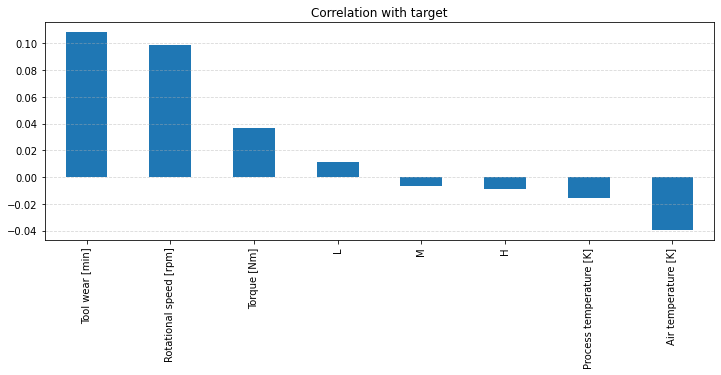

In [23]:
preprocessed_data.drop('Failure Type', axis=1).corrwith(preprocessed_data['Failure Type']).sort_values(ascending=False).plot(kind='bar', figsize=(12,4), title='Correlation with target')
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()

Применим тест хи-квадрат, предварительно приведя признаки к категориальному виду, чтобы выяснить, какой дискриминативной способностью обладают признаки.

In [24]:
data_chi2 = preprocessed_data.copy()
data_chi2['Air temperature [K]'] = pd.cut(data_chi2['Air temperature [K]'], 50, labels=np.arange(50), duplicates='raise')
data_chi2['Process temperature [K]'] = pd.cut(data_chi2['Process temperature [K]'], 50, labels=np.arange(50), duplicates='raise')
data_chi2['Rotational speed [rpm]'] = pd.cut(data_chi2['Rotational speed [rpm]'], 50, labels=np.arange(50), duplicates='raise')
data_chi2['Torque [Nm]'] = pd.cut(data_chi2['Torque [Nm]'], 50, labels=np.arange(50), duplicates='raise')
data_chi2['Tool wear [min]'] = pd.cut(data_chi2['Tool wear [min]'], 50, labels=np.arange(50), duplicates='raise')
chi2_result = chi2(data_chi2.drop('Failure Type', axis=1), data_chi2['Failure Type'])
chi2_result = pd.DataFrame(chi2_result).T.set_index(data_chi2.drop('Failure Type', axis=1).columns).rename(columns={0:'ChiSqr_Score', 1:"ChiSqr_pValue"}).sort_values(by='ChiSqr_Score', ascending=False)
print(chi2_result)

                         ChiSqr_Score  ChiSqr_pValue
Tool wear [min]           2499.838076   0.000000e+00
Rotational speed [rpm]     989.437283  6.944789e-213
Torque [Nm]                953.325818  4.645691e-205
Air temperature [K]        884.525152  3.753746e-190
Process temperature [K]    108.756027   1.340498e-22
M                           16.838191   2.077985e-03
L                           15.759352   3.359676e-03
H                            9.661436   4.653373e-02


При уровне статистической значимости 0.05 все признаки являются значимыми, однако с целью уменьшения корреляции между типами установок удалим признак 'H' из рассмотрения, тем более что он имеет наименьшую корреляцию с таргетом и наименьшую дискриминативую способность согласно тесту хи-квадрат.

In [25]:
preprocessed_data.drop('H', axis=1, inplace=True)

## Построение модели для определения типа поломки установки

Разобьём наши данные на обучающую и на тестирующую выборку.

In [26]:
Y = preprocessed_data['Failure Type'].copy()
X = preprocessed_data.drop('Failure Type', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
for i in [Y_train, Y_test]:
    print(i.value_counts())

Failure Type
1    8201
0      92
3      79
2      65
4      40
Name: count, dtype: int64
Failure Type
1    1442
0      20
3      16
2      13
4       5
Name: count, dtype: int64


Выполним предварительную обработку данных, чтобы свести значения к единому порядку. Для этого будем использовать RobustScaler для вращательной скорости и крутящего момента (поскольку там имеются экстремальные значения, которые теоретически могут оказаться выбросами) и MaxAbsScaler для остальных признаков.

In [27]:
rob_scaler = RobustScaler().fit(X_train[['Rotational speed [rpm]', 'Torque [Nm]']])
upd_rs_torque_train = rob_scaler.transform(X_train[['Rotational speed [rpm]', 'Torque [Nm]']])
upd_rs_torque_test = rob_scaler.transform(X_test[['Rotational speed [rpm]', 'Torque [Nm]']])
upd_rs_torque_train = pd.DataFrame(upd_rs_torque_train, columns=['Rotational speed', 'Torque'])
upd_rs_torque_test = pd.DataFrame(upd_rs_torque_test, columns=['Rotational speed', 'Torque'])
X_train = pd.concat([X_train.drop(['Rotational speed [rpm]', 'Torque [Nm]'], axis=1), upd_rs_torque_train], axis=1)
X_test = pd.concat([X_test.drop(['Rotational speed [rpm]', 'Torque [Nm]'], axis=1), upd_rs_torque_test], axis=1)

maxabs_scaler = MaxAbsScaler().fit(X_train[['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']])
upd_at_pt_tw_train = maxabs_scaler.transform(X_train[['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']])
upd_at_pt_tw_test = maxabs_scaler.transform(X_test[['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']])
upd_at_pt_tw_train = pd.DataFrame(upd_at_pt_tw_train, columns=['Air temperature', 'Process temperature', 'Tool wear'])
upd_at_pt_tw_test = pd.DataFrame(upd_at_pt_tw_test, columns=['Air temperature', 'Process temperature', 'Tool wear'])
X_train = pd.concat([X_train.drop(['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]'], axis=1), upd_at_pt_tw_train], axis=1)
X_test = pd.concat([X_test.drop(['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]'], axis=1), upd_at_pt_tw_test], axis=1)

Ниже прилагается код поиска оптимальных гиперпараметров через OPTUNA. Я уже выполнил поиск гиперпараметров, однако при необходимости повторного поиска из кода следует удалить символы '''.

In [28]:
'''def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 4, 12)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 2**max_depth - 1)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_samples = trial.suggest_float('max_samples', 0.5, 1)
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_features=max_features, max_leaf_nodes=max_leaf_nodes, class_weight=class_weight, max_samples=max_samples)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=1000)'''

'''def objective_gb(trial):
    opt_max_depth = trial.suggest_int('opt_max_depth', 4, 12)
    opt_max_leaf_nodes = trial.suggest_int('opt_max_leaf_nodes', 10, 2**opt_max_depth - 1)
    opt_min_samples_leaf = trial.suggest_int('opt_min_samples_leaf', 1, 1000)
    opt_l2_reg = trial.suggest_float('opt_l2_reg', 1e-12, 1e6, log=True)
    model = HistGradientBoostingClassifier(learning_rate=0.01, max_iter=8000, max_depth=opt_max_depth, max_leaf_nodes=opt_max_leaf_nodes, min_samples_leaf=opt_min_samples_leaf, l2_regularization=opt_l2_reg, early_stopping=True, n_iter_no_change=100, class_weight='balanced', verbose=0)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_gb, n_trials=500)'''

'''def objective_brf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 4, 12)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 2**max_depth - 1)
    max_samples = trial.suggest_float('max_samples', 0.5, 1)
    model = BalancedRandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, max_features=max_features, max_samples=max_samples)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = balanced_accuracy_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_brf, n_trials=500)'''
pass

В своей работе я принял решение использовать следующие модели:<br>
1) Случайный лес из scikit-learn<br>
2) Гистограммный градиентный бустинг из scikit-learn<br>
3) Сбалансированный случайный лес из imblearn<br>
4) AdaBoost, в который интегрирован RandomUnderSampler для балансировки на каждой итерации бустинга из imblearn<br>
5) Бэггинг над AdaBoost, каждый из которых обучался на сбалансированной части данных, из imbleran

In [29]:
RF_classifier = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=6, max_features=1.0, max_leaf_nodes=42, class_weight='balanced_subsample', max_samples=0.7435171108236761, verbose=0)
GB_classifier = HistGradientBoostingClassifier(max_iter=8000, learning_rate=0.01, max_depth=10,  max_leaf_nodes=223, min_samples_leaf=93, n_iter_no_change=100, verbose=0, l2_regularization=20.392498475209592, early_stopping=True, class_weight='balanced')
BRF_classifier = BalancedRandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=9, max_leaf_nodes=295, max_features=0.7, max_samples=0.7379646655432375, verbose=0)
RUS_classifier = RUSBoostClassifier(n_estimators=1000, learning_rate=0.05)
EE_classifier = EasyEnsembleClassifier(n_estimators=1000, verbose=0)


RF_classifier.fit(X_train, Y_train)
GB_classifier.fit(X_train, Y_train)
BRF_classifier.fit(X_train, Y_train)
RUS_classifier.fit(X_train, Y_train)
EE_classifier.fit(X_train, Y_train)

EasyEnsembleClassifier(n_estimators=1000)

In [30]:
y_pred_train_1 = RF_classifier.predict(X_train)
y_pred_train_2 = GB_classifier.predict(X_train)
y_pred_train_3 = BRF_classifier.predict(X_train)
y_pred_train_4 = RUS_classifier.predict(X_train)
y_pred_train_5 = EE_classifier.predict(X_train)


y_pred_test_1 = RF_classifier.predict(X_test)
y_pred_test_2 = GB_classifier.predict(X_test)
y_pred_test_3 = BRF_classifier.predict(X_test)
y_pred_test_4 = RUS_classifier.predict(X_test)
y_pred_test_5 = EE_classifier.predict(X_test)

print('train 1 balanced accuracy ', balanced_accuracy_score(Y_train, y_pred_train_1))
print('train 2 balanced accuracy ', balanced_accuracy_score(Y_train, y_pred_train_2))
print('train 3 balanced accuracy ', balanced_accuracy_score(Y_train, y_pred_train_3))
print('train 4 balanced accuracy ', balanced_accuracy_score(Y_train, y_pred_train_4))
print('train 5 balanced accuracy ', balanced_accuracy_score(Y_train, y_pred_train_5))


print('test 1 balanced accuracy ', balanced_accuracy_score(Y_test, y_pred_test_1))
print('test 2 balanced accuracy ', balanced_accuracy_score(Y_test, y_pred_test_2))
print('test 3 balanced accuracy ', balanced_accuracy_score(Y_test, y_pred_test_3))
print('test 4 balanced accuracy ', balanced_accuracy_score(Y_test, y_pred_test_4))
print('test 5 balanced accuracy ', balanced_accuracy_score(Y_test, y_pred_test_5))


y_pred_train_1_proba = RF_classifier.predict_proba(X_train)
y_pred_train_2_proba = GB_classifier.predict_proba(X_train)
y_pred_train_3_proba = BRF_classifier.predict_proba(X_train)
y_pred_train_4_proba = RUS_classifier.predict_proba(X_train)
y_pred_train_5_proba = EE_classifier.predict_proba(X_train)


y_pred_test_1_proba = RF_classifier.predict_proba(X_test)
y_pred_test_2_proba = GB_classifier.predict_proba(X_test)
y_pred_test_3_proba = BRF_classifier.predict_proba(X_test)
y_pred_test_4_proba = RUS_classifier.predict_proba(X_test)
y_pred_test_5_proba = EE_classifier.predict_proba(X_test)

print('train 1 roc auc ', roc_auc_score(Y_train, y_pred_train_1_proba, average="weighted", multi_class='ovr'))
print('train 2 roc auc ', roc_auc_score(Y_train, y_pred_train_2_proba, average="weighted", multi_class='ovr'))
print('train 3 roc auc ', roc_auc_score(Y_train, y_pred_train_3_proba, average="weighted", multi_class='ovr'))
print('train 4 roc auc ', roc_auc_score(Y_train, y_pred_train_4_proba, average="weighted", multi_class='ovr'))
print('train 5 roc auc ', roc_auc_score(Y_train, y_pred_train_5_proba, average="weighted", multi_class='ovr'))


print('test 1 roc auc ', roc_auc_score(Y_test, y_pred_test_1_proba, average="weighted", multi_class='ovr'))
print('test 2 roc auc ', roc_auc_score(Y_test, y_pred_test_2_proba, average="weighted", multi_class='ovr'))
print('test 3 roc auc ', roc_auc_score(Y_test, y_pred_test_3_proba, average="weighted", multi_class='ovr'))
print('test 4 roc auc ', roc_auc_score(Y_test, y_pred_test_4_proba, average="weighted", multi_class='ovr'))
print('test 5 roc auc ', roc_auc_score(Y_test, y_pred_test_5_proba, average="weighted", multi_class='ovr'))


print('train 1 classification report ', classification_report(Y_train, y_pred_train_1))
print('train 2 classification report ', classification_report(Y_train, y_pred_train_2))
print('train 3 classification report ', classification_report(Y_train, y_pred_train_3))
print('train 4 classification report ', classification_report(Y_train, y_pred_train_4))
print('train 5 classification report ', classification_report(Y_train, y_pred_train_5))


print('test 1 classification report ', classification_report(Y_test, y_pred_test_1))
print('test 2 classification report ', classification_report(Y_test, y_pred_test_2))
print('test 3 classification report ', classification_report(Y_test, y_pred_test_3))
print('test 4 classification report ', classification_report(Y_test, y_pred_test_4))
print('test 5 classification report ', classification_report(Y_test, y_pred_test_5))

train 1 balanced accuracy  0.9742720050986439
train 2 balanced accuracy  0.9734561546214648
train 3 balanced accuracy  0.9527741493556171
train 4 balanced accuracy  0.6283734942330808
train 5 balanced accuracy  0.8306970713300694
test 1 balanced accuracy  0.8784228635442227
test 2 balanced accuracy  0.9608983249759948
test 3 balanced accuracy  0.9275765496639282
test 4 balanced accuracy  0.6647783527152459
test 5 balanced accuracy  0.7679376933745866
train 1 roc auc  0.9815528934703189
train 2 roc auc  0.9925895429938537
train 3 roc auc  0.9860963133472582
train 4 roc auc  0.8934831022685997
train 5 roc auc  0.9031759473600436
test 1 roc auc  0.9693546537285689
test 2 roc auc  0.9817648991337629
test 3 roc auc  0.9679489418046242
test 4 roc auc  0.8720260085774557
test 5 roc auc  0.8896322989008346
train 1 classification report                precision    recall  f1-score   support

           0       0.49      0.99      0.65        92
           1       1.00      0.92      0.96      8

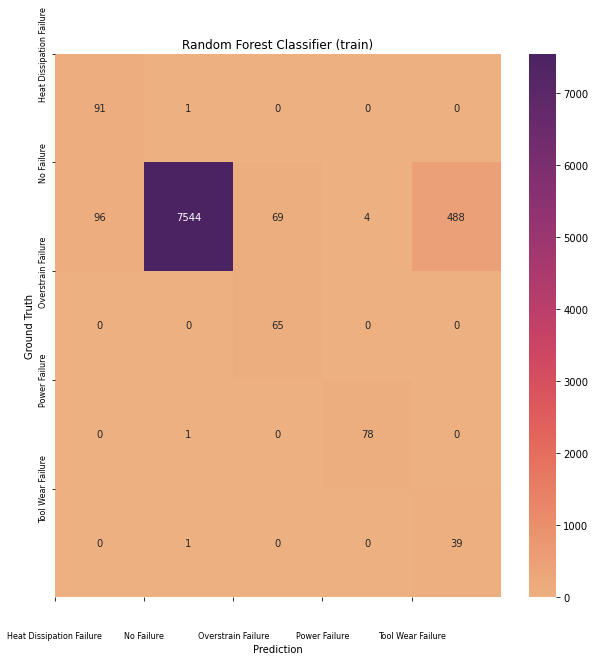

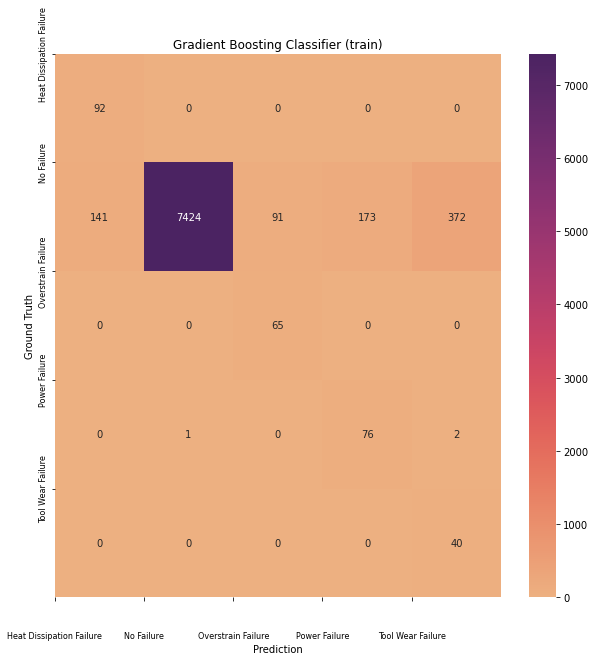

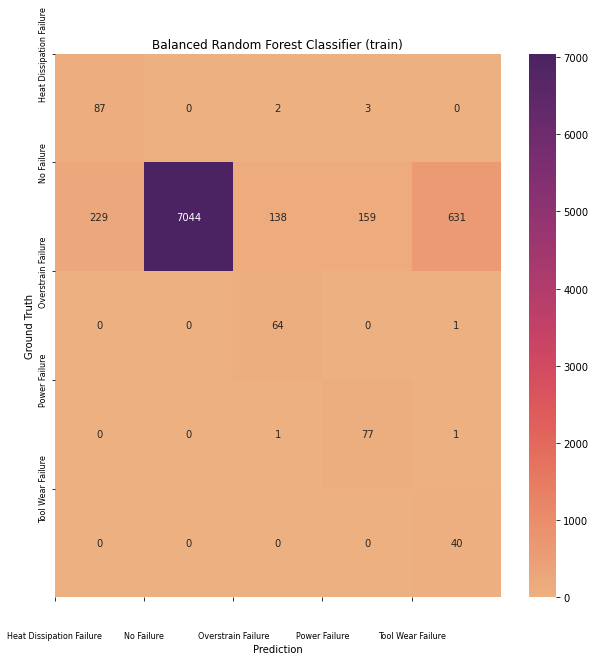

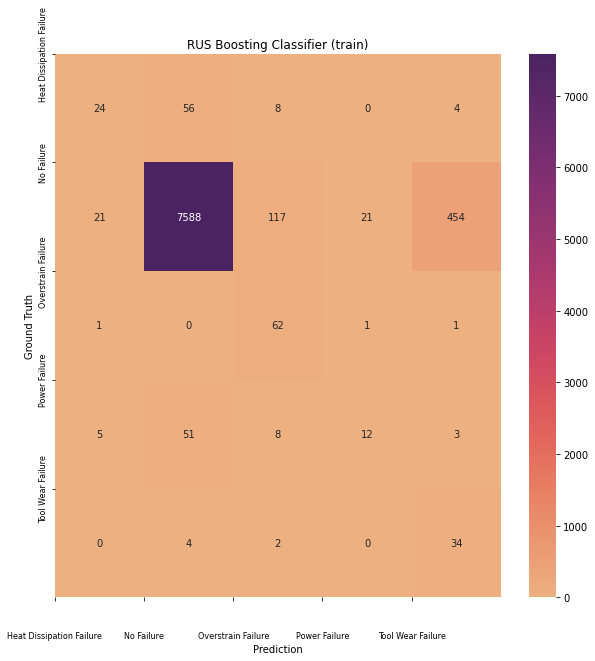

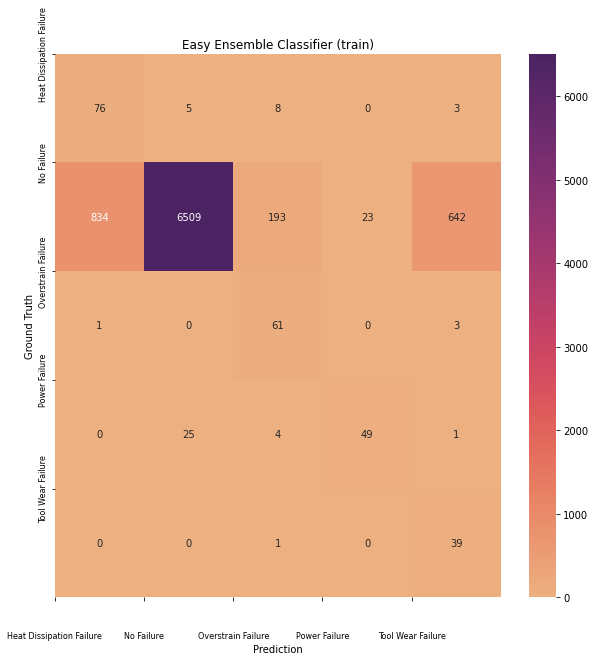

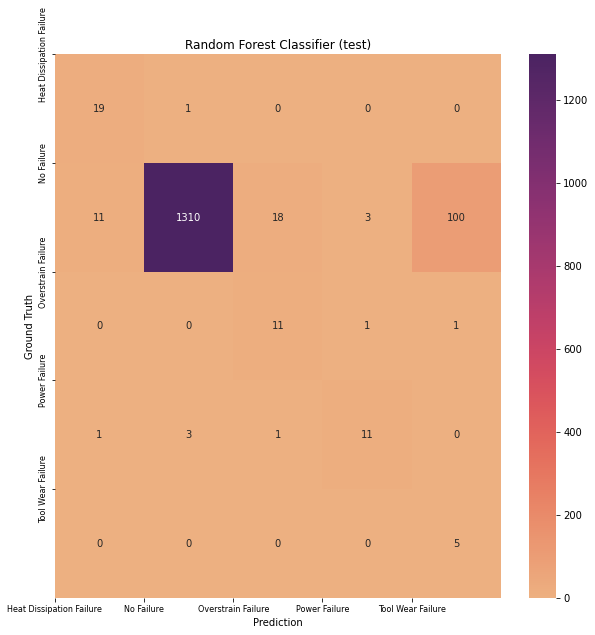

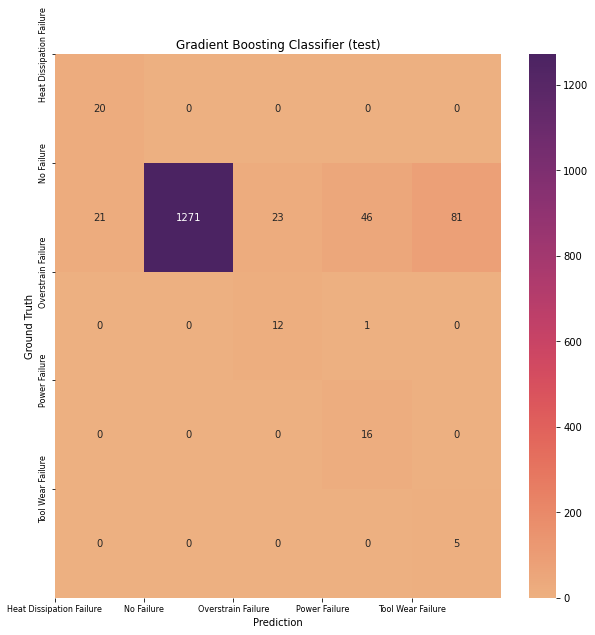

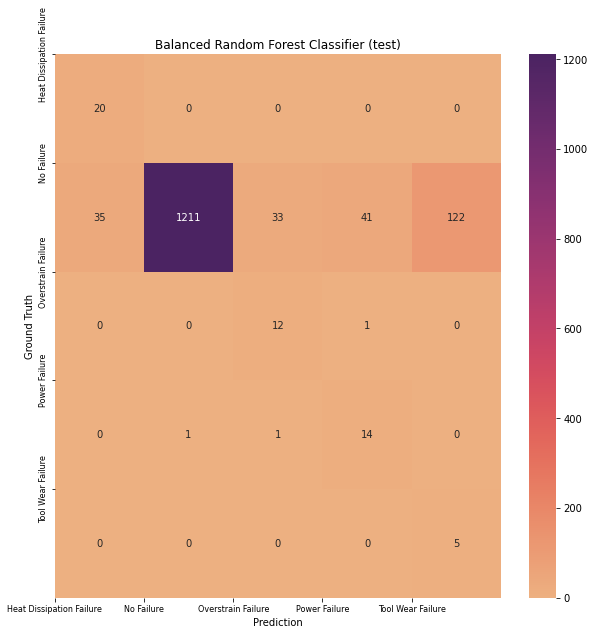

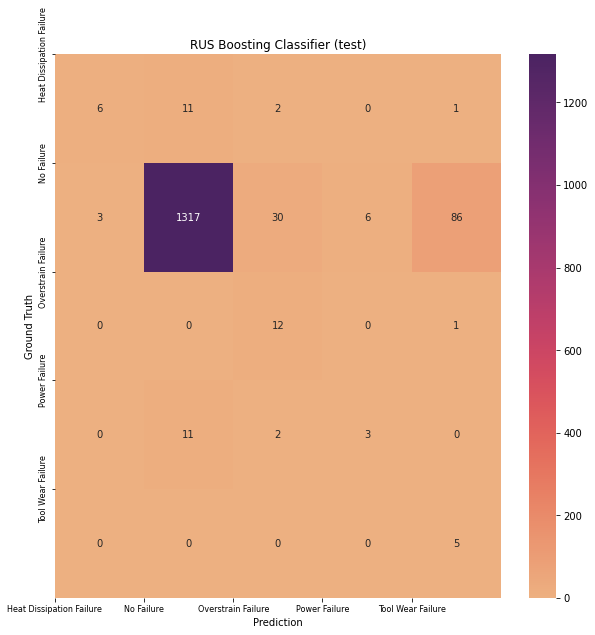

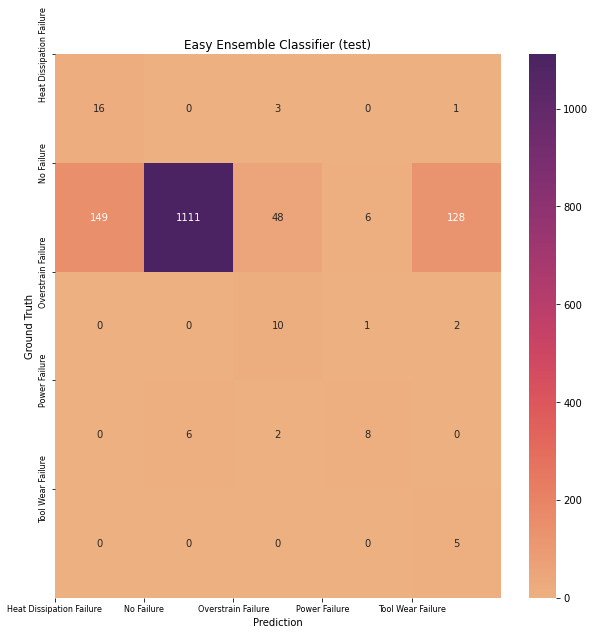

In [31]:
confustion_matrix_1_train = confusion_matrix(Y_train, y_pred_train_1)
confustion_matrix_2_train = confusion_matrix(Y_train, y_pred_train_2)
confustion_matrix_3_train = confusion_matrix(Y_train, y_pred_train_3)
confustion_matrix_4_train = confusion_matrix(Y_train, y_pred_train_4)
confustion_matrix_5_train = confusion_matrix(Y_train, y_pred_train_5)

confustion_matrix_1_test = confusion_matrix(Y_test, y_pred_test_1)
confustion_matrix_2_test = confusion_matrix(Y_test, y_pred_test_2)
confustion_matrix_3_test = confusion_matrix(Y_test, y_pred_test_3)
confustion_matrix_4_test = confusion_matrix(Y_test, y_pred_test_4)
confustion_matrix_5_test = confusion_matrix(Y_test, y_pred_test_5)

names = ['Random Forest Classifier', 'Gradient Boosting Classifier', 'Balanced Random Forest Classifier', 'RUS Boosting Classifier', 'Easy Ensemble Classifier']
matrices_train = [confustion_matrix_1_train, confustion_matrix_2_train, confustion_matrix_3_train, confustion_matrix_4_train, confustion_matrix_5_train]
matrices_test = [confustion_matrix_1_test, confustion_matrix_2_test, confustion_matrix_3_test, confustion_matrix_4_test, confustion_matrix_5_test]
heatmap_labels = label2int.classes_

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.title(names[i] + " (train)")
    sns.heatmap(matrices_train[i], cmap='flare', annot=True, fmt='d')
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=heatmap_labels, fontsize=8)
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=heatmap_labels, fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis='x', which='both', pad=30)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.show()

for i in range(5):
    plt.figure(figsize=(10,10))
    plt.title(names[i] + " (test)")
    sns.heatmap(matrices_test[i], cmap='flare', annot=True, fmt='d')
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=heatmap_labels, fontsize=8)
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=heatmap_labels, fontsize=8)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.show()

Лучшей моделью для решения данной задачи оказался гистограммный градиентный бустинг (scikit-learn) с ROC AUC 98%.